# Exploring the effect of shifting baseline

### Data used in this analysis: ESPO-G6-E5L v1.0.0, ERA5-Land Hourly 
<br>ERA5 (Reanalyzed data): Combine model data with observation for assimilation. Thus creating improved version of orignial observations.
<br>For more information: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview
<br><br>ESPO-G6-E5L v1.0.0 (Model data): An ensemble of bias-adjusted CMIP6 climate simulations on North America. 
<Br>For more information: https://github.com/Ouranosinc/ESPO-G

Source: 
<br><br>Lavoie, J., Bourgault, P., Logan, T., Caron, L.-P., Gammon, S., Smith, T. J., Biner, S., & Leduc, M. (2023). ESPO-G6-E5L : Ensemble de Simulations Post-traitées d'Ouranos - modèles Globaux CMIP6 - ERA5-Land / Ouranos Ensemble of Bias-adjusted Simulations - Global Models CMIP6 - ERA5-Land (ESPO-G6-E5Lv1.0.0). Zenodo. https://doi.org/10.5281/zenodo.7764929
<br><br>Muñoz Sabater, J. (2019): ERA5-Land hourly data from 1950 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.e2161bac  (Accessed on 21-May-2024)

### Load packages

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.stats as st
from pathlib import Path
import cftime as cf
import matplotlib as mpl
import seaborn as sns
mpl.rc('font',size=14)

## Read in model and renalysis data
Create dictionaries for storage

In [2]:
# Variables for cities
folders=['Calgary']
# folders=['Calgary','GTA','Halifax','Montreal','Vancouver']
sub_folders=['CAL']
# sub_folders=['CAL','GTA','HAL','MON','VAN']
# Create dictonaries
raw_data_245={}
raw_data_370={}
raw_ensemble_ssp245={}
raw_ensemble_ssp370={}
raw_era_data={}
maps={}

In [3]:
for fol,sub_f in zip(folders,sub_folders):
    print(fol,'start')
# Individual models
    # raw_data_245[fol]={file.stem :xr.open_dataset(file,drop_variables=['pr','tasmax','tasmin'],chunks={'time':-1}) for file in Path('C:/Users/edmun/Documents/UOFT/summer_intern/data_raw/model_data/'+fol+'/ssp245/').glob('*.nc')}
    # raw_data_370[fol]={file.stem :xr.open_dataset(file,drop_variables=['pr','tasmax','tasmin'],chunks={'time':-1}) for file in Path('C:/Users/edmun/Documents/UOFT/summer_intern/data_raw/model_data/'+fol+'/ssp370/').glob('*.nc')}

# Ensemble
    raw_ensemble_ssp245[fol]=xr.open_mfdataset('C:/Users/edmun/Documents/UOFT/summer_intern/data_raw/model_data/'+fol+'/ssp245/*.nc',drop_variables=['pr'],combine='nested',concat_dim='model',chunks={"time":-1,'model':-1})
    raw_ensemble_ssp370[fol]=xr.open_mfdataset('C:/Users/edmun/Documents/UOFT/summer_intern/data_raw/model_data/'+fol+'/ssp370/*.nc',drop_variables=['pr'],combine='nested',concat_dim='model',chunks={"time":-1,'model':-1})
# ERA5 data
    raw_era_data[fol]=xr.open_mfdataset('C:/Users/edmun/Documents/UOFT/summer_intern/data_raw/model_data/'+fol+'/era5_*/era5_land_'+sub_f+'/*.nc',chunks={"time":-1})

# Load map of each city
    maps[fol]=[gpd.read_file(file) for file in Path('C:/Users/edmun/Documents/UOFT/summer_intern/github/maps/'+sub_f+'/').glob('*.shp')]

Calgary start


## Data Transformation

In [4]:
# Create empty dictionary
era_tmean_modified={}
era_tmin_modified={}
era_tmax_modified={}
for fol in folders:
    print(fol,'start')
# Convert ERA5-Land data datetime
    raw_era_data[fol]=raw_era_data[fol].convert_calendar('360_day',align_on='date')
# Convert to daily data
    era_tmean_modified[fol]=raw_era_data[fol].resample(time='1D').mean('time')-273.15
    era_tmin_modified[fol]=raw_era_data[fol].resample(time='1D').min('time')-273.15
    era_tmax_modified[fol]=raw_era_data[fol].resample(time='1D').max('time')-273.15
# Finally we will have to regrid to match the model data
    era_tmean_modified[fol]=era_tmean_modified[fol].interp(latitude=raw_ensemble_ssp245[fol].lat,longitude=raw_ensemble_ssp245[fol].lon)
    era_tmin_modified[fol]=era_tmin_modified[fol].interp(latitude=raw_ensemble_ssp245[fol].lat,longitude=raw_ensemble_ssp245[fol].lon)
    era_tmax_modified[fol]=era_tmax_modified[fol].interp(latitude=raw_ensemble_ssp245[fol].lat,longitude=raw_ensemble_ssp245[fol].lon)

Calgary start


#### Now check the modified ERA5 data

# Clipping

<br>Source: Land Information Ontario. Topographic Map Maker [digital resource: raster]. Greater Toronto Area (GTA) 2013 Orthophotography
. Retrieved 05-27-2024, from https://www.arcgis.com/home/item.html?id=9ed81541fead4f5ba9b497d92df42f41.
<br><br>
Statistics Canada. (2021) 2021 Census – Boundary files [Data set]. Retrieved 05-15-2024, from https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index2021-eng.cfm?year=21.

In [5]:
def clipping(dataset,city):
    shp=[gpd.read_file(file) for file in Path('C:/Users/edmun/Documents/UOFT/summer_intern/github/maps/'+city+'/').glob('*.shp')]
    data_clipped=dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
    data_clipped=data_clipped.rio.write_crs("epsg:4326")
    data_clipped=data_clipped.rio.clip(shp[0].geometry.values,shp[0].crs, drop = False, invert = False)
    return data_clipped


In [6]:
ensemble_245_clipped={}
ensemble_370_clipped={}
raw_data_245_clipped={}
raw_data_370_clipped={}
era_tmean_clipped={}
era_tmin_clipped={}
era_tmax_clipped={}
for fol,sub_f in zip(folders,sub_folders):
    print(fol,'start')
    ensemble_245_clipped[fol]=clipping(raw_ensemble_ssp245[fol],sub_f)
    ensemble_370_clipped[fol]=clipping(raw_ensemble_ssp370[fol],sub_f)
    era_tmean_clipped[fol]=clipping(era_tmean_modified[fol],sub_f)
    era_tmin_clipped[fol]=clipping(era_tmin_modified[fol],sub_f)
    era_tmax_clipped[fol]=clipping(era_tmax_modified[fol],sub_f)


Calgary start


# Assessing future 

## Temperature Normals

Tri-decadal period (2021 - 2050 , 2051 - 2080, 2081 - 2100)

In [7]:
# define periods
years=[2021,2051,2071]

# Create dictionaries
# d: daily m: monthly
ensemble_245_normal_m={}
ensemble_245_normal_d={}
ensemble_245_annual={}
ensemble_245={}
ensemble_370_normal_m={}
ensemble_370_normal_d={}
ensemble_370_annual={}
ensemble_370={}
baseline_tmean={}
baseline_tmin={}
baseline_tmax={}
baseline_tmean_annual={}
baseline_tmin_annual={}
baseline_tmax_annual={}
baseline_tmean_normal_m={}
baseline_tmin_normal_m={}
baseline_tmax_normal_m={}
baseline_tmean_normal_d={}
baseline_tmin_normal_d={}
baseline_tmax_normal_d={}
for city in folders:
    print(city)
    ensemble_245[city]={}
    ensemble_370[city]={}
    ensemble_245_normal_m[city]={}
    ensemble_370_normal_m[city]={}
    ensemble_245_normal_d[city]={}
    ensemble_370_normal_d[city]={}
    ensemble_245_annual[city]={}
    ensemble_370_annual[city]={}
# Baseline
    baseline_tmean[city]=era_tmean_clipped[city].sel(time=slice('1991-01-01','2020-12-30')).mean(['lat','lon']).t2m
    baseline_tmin[city]=era_tmin_clipped[city].sel(time=slice('1991-01-01','2020-12-30')).mean(['lat','lon']).t2m
    baseline_tmax[city]=era_tmax_clipped[city].sel(time=slice('1991-01-01','2020-12-30')).mean(['lat','lon']).t2m
# Annual
    baseline_tmean_annual[city]=baseline_tmean[city].groupby('time.year').mean(['time'])
    baseline_tmin_annual[city]=baseline_tmin[city].groupby('time.year').mean(['time'])
    baseline_tmax_annual[city]=baseline_tmax[city].groupby('time.year').mean(['time'])
# Daily Normals
    baseline_tmean_normal_d[city]=baseline_tmean[city].groupby('time.dayofyear').mean(['time'])
    baseline_tmin_normal_d[city]=baseline_tmin[city].groupby('time.dayofyear').mean(['time'])
    baseline_tmax_normal_d[city]=baseline_tmax[city].groupby('time.dayofyear').mean(['time'])
# Monthly Normals
    baseline_tmean_normal_m[city]=baseline_tmean[city].groupby('time.month').mean(['time'])
    baseline_tmin_normal_m[city]=baseline_tmin[city].groupby('time.month').mean(['time'])
    baseline_tmax_normal_m[city]=baseline_tmax[city].groupby('time.month').mean(['time'])
    for year in years:
        year_start=str(year)
        year_end=str(year+29)
# Slicing 
        ensemble_245[city][year_start+'_'+year_end]=ensemble_245_clipped[city].sel(time=slice(year_start+'-01-01',
                                                     year_end+'-12-30')).mean(['lat','lon'])
        ensemble_370[city][year_start+'_'+year_end]=ensemble_370_clipped[city].sel(time=slice(year_start+'-01-01',
                                                     year_end+'-12-30')).mean(['lat','lon'])
# Daily Normals    
        ensemble_245_normal_d[city][year_start+'_'+year_end]=ensemble_245[city][year_start+'_'+year_end].groupby('time.dayofyear').mean(['time'])
        ensemble_370_normal_d[city][year_start+'_'+year_end]=ensemble_370[city][year_start+'_'+year_end].groupby('time.dayofyear').mean(['time'])

# Monthly Normals
        ensemble_245_normal_m[city][year_start+'_'+year_end]=ensemble_245[city][year_start+'_'+year_end].groupby('time.month').mean(['time'])
        ensemble_370_normal_m[city][year_start+'_'+year_end]=ensemble_370[city][year_start+'_'+year_end].groupby('time.month').mean(['time'])

# Annual temperature
        ensemble_245_annual[city][year_start+'_'+year_end]=ensemble_245[city][year_start+'_'+year_end].groupby('time.year').mean(['time'])
        ensemble_370_annual[city][year_start+'_'+year_end]=ensemble_370[city][year_start+'_'+year_end].groupby('time.year').mean(['time'])

    

Calgary


Calgary


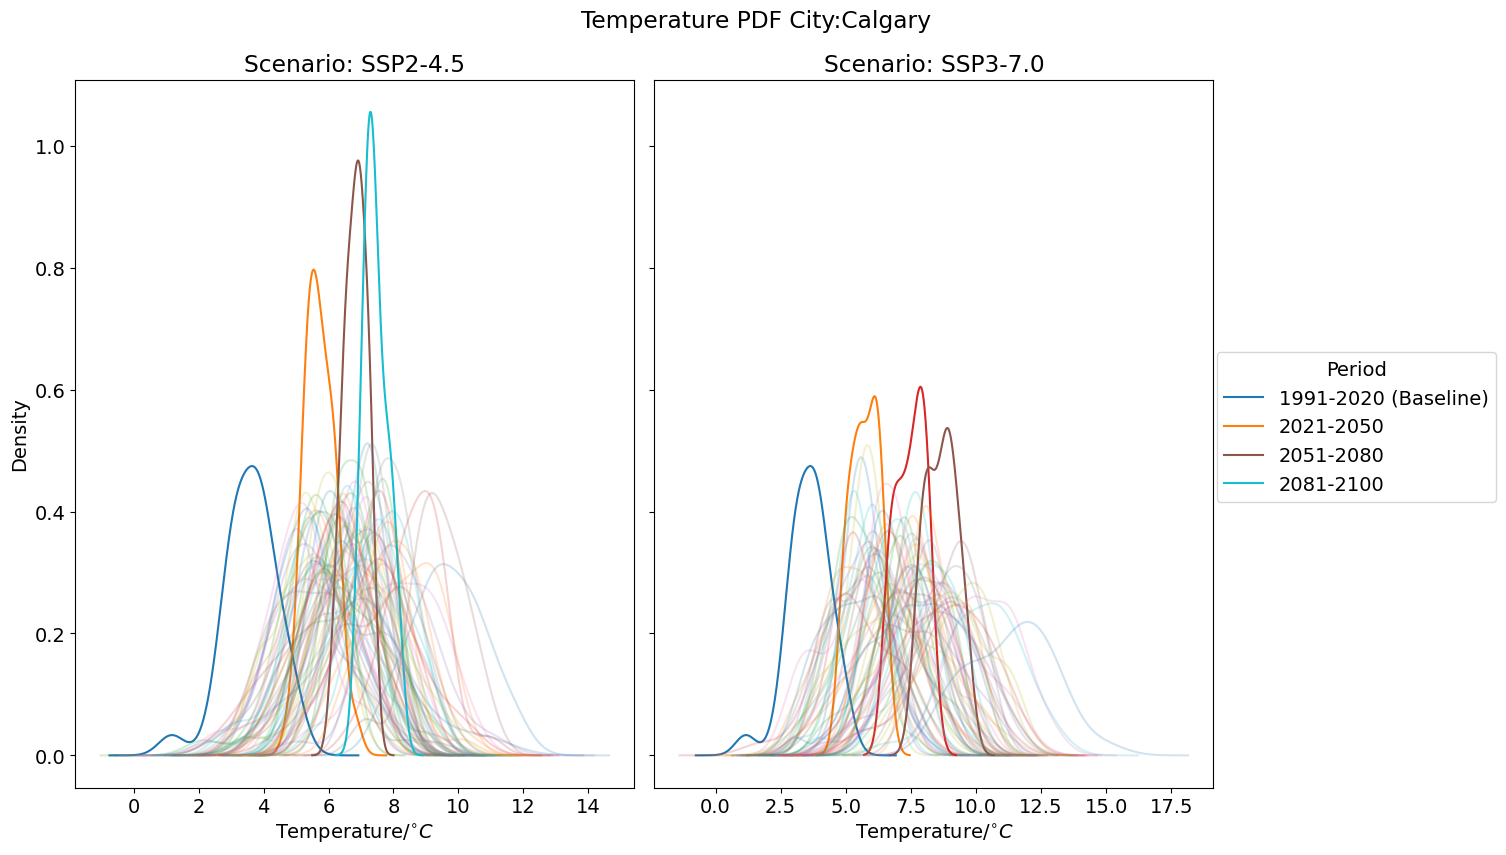

In [8]:
# Annual Mean Temperature PDF for cities and scenarios
for city in folders:
    print(city)
    fig,ax=plt.subplots(1,2,figsize=(15,8),layout='constrained',sharey=True)
    fig.suptitle('Temperature PDF City:'+city,y=1.05)
# Baseline
    baseline_tmean_annual[city].to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.density(ax=ax[0],legend=False)
    baseline_tmean_annual[city].to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.density(ax=ax[1],legend=False)
# Ensemble    
    for period in ensemble_245_annual[city].keys():
        ensemble_245_annual[city][period].mean(['model']).tasmean.to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.density(ax=ax[0],legend=False)
        ensemble_370_annual[city][period].mean(['model']).tasmean.to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.density(ax=ax[1],legend=False)
# Individual models
        for i in ensemble_245_annual[city][period].model:
            ensemble_245_annual[city][period].sel(model=i).tasmean.to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.kde(ax=ax[0],alpha=0.2,legend=False)
        for i in ensemble_370_annual[city][period].model:
            ensemble_370_annual[city][period].sel(model=i).tasmean.to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.kde(ax=ax[1],alpha=0.2,legend=False)
# Labels
    ax[0].set_xlabel('Temperature/$^{\circ}C$')
    ax[1].set_xlabel('Temperature/$^{\circ}C$')
    h,l = ax[0].get_legend_handles_labels()
    ax[0].set_title('Scenario: SSP2-4.5')
    ax[1].set_title('Scenario: SSP3-7.0')
    fig.legend([h[0],h[1],h[25],h[49]],['1991-2020 (Baseline)','2021-2050','2051-2080','2081-2100'],title='Period', loc='outside right')
    # ax[0].legend([h[0],h[1],h[25],h[49]],['Baseline 1991-2020','2021-2050','2051-2080','2081-2100'],title='Period')
    # ax[1].legend([h1[0],h1[1],h1[23],h1[47]],['Baseline 1991-2020','2021-2050','2051-2080','2081-2100'],title='Period')
    

Calgary


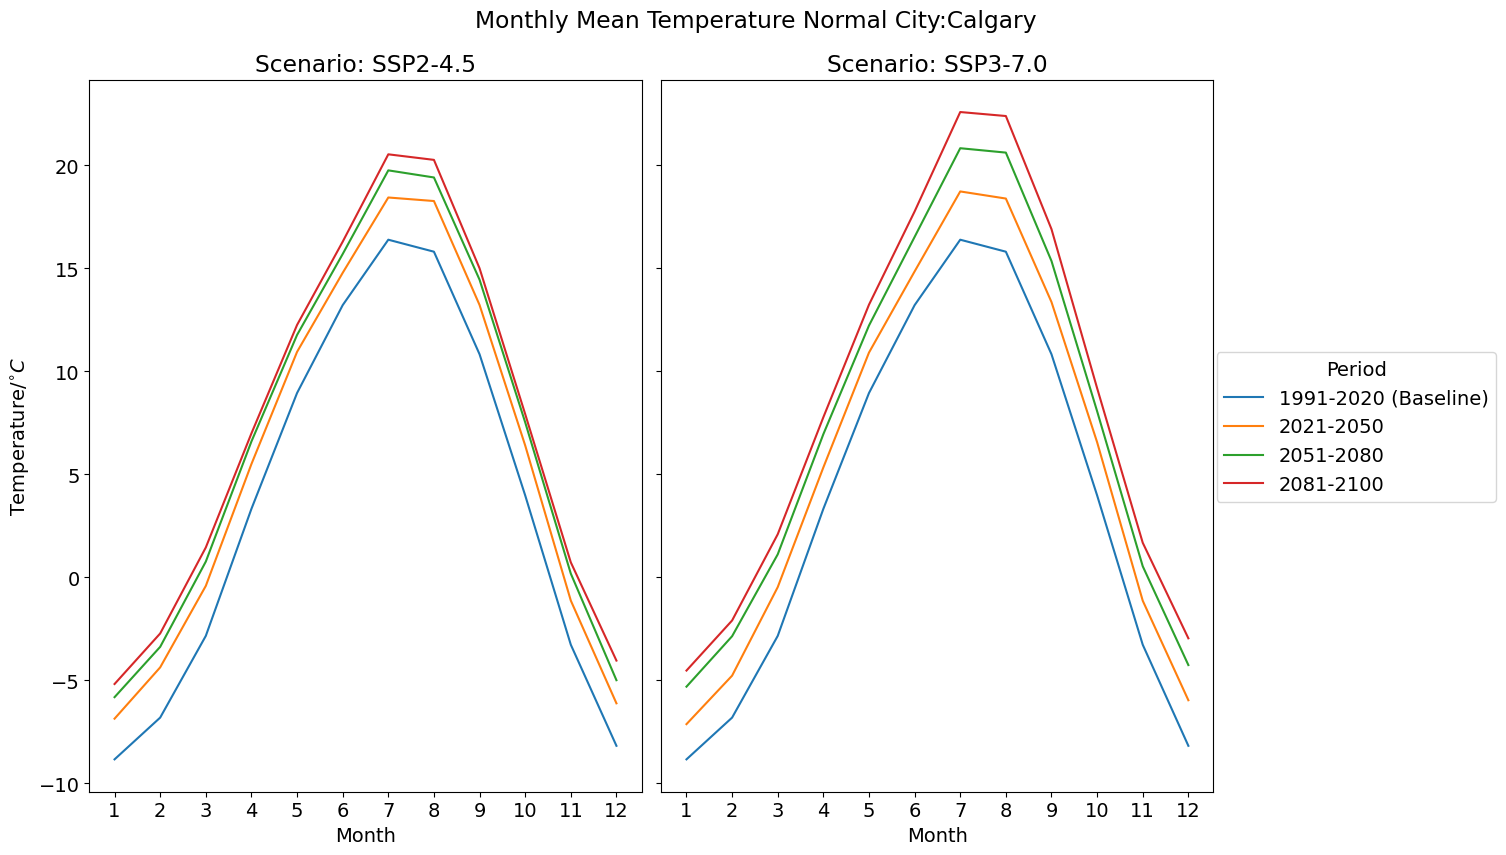

In [9]:
for city in folders:
    print(city)
    fig,ax=plt.subplots(1,2,figsize=(15,8),layout='constrained',sharey=True,sharex=True)
    fig.suptitle('Monthly Mean Temperature Normal City:'+city,y=1.05)
    baseline_tmean_normal_m[city].plot(ax=ax[0])
    baseline_tmean_normal_m[city].plot(ax=ax[1])
    for period in ensemble_245_normal_m[city].keys():
        ensemble_245_normal_m[city][period].mean(['model']).tasmean.plot(ax=ax[0])
        ensemble_370_normal_m[city][period].mean(['model']).tasmean.plot(ax=ax[1])
    ax[0].set_ylabel('Temperature/$^{\circ}C$')
    ax[1].set_ylabel('')
    ax[0].set_xticks(np.arange(1,13,1),np.arange(1,13,1))
    ax[1].set_xticks(np.arange(1,13,1),np.arange(1,13,1))
    ax[0].set_xlabel('Month')
    ax[1].set_xlabel('Month')
    ax[0].set_title('Scenario: SSP2-4.5')
    ax[1].set_title('Scenario: SSP3-7.0')
    fig.legend(['1991-2020 (Baseline)','2021-2050','2051-2080','2081-2100'],title='Period', loc='outside right')
    

# Shifting Baseline

<br><br>The projection of temperature above is computed with a stationary baseline, which means the 30-year reference period remains the same for the entire time series. Now, we will look at the impact of shifting baseline, which means the reference period will be moving along with the projection for every decade.
<br><br>For example:
| Time Period of Interest | 2021 - 2050 | 2051 - 2080 | 2081 - 2100
| --- | --- | --- | --- |
| Stationary Baseline | 1991 - 2020 | 1991 - 2020 | 1991 - 2020 |
| Shifting Baseline | 2011 - 2040 | 2041 - 2070 | 2071 - 2090 |

In [127]:
# Function generate shifting and stationary baseline temperature anomalies
def create_baseline(model,city,par='mean',scen='370',method='shifting'): #The default method for this function would be shifting baseline 
     if method=='shifting':
          if par=='mean':
               series=model[city].tasmean
          elif par=='min':
               series=model[city].tasmin
          elif par =='max':
               series=model[city].tasmax
     # for shifting baseline
          data=series.sel(time=slice('1960-01-01','2100-12-30'))-series.sel(time=slice('1950-01-01','2090-12-30')).to_numpy()
     # for stationary baseline:
     elif method=='stationary':
          if par=='mean':
               series=model[city].tasmean
               if scen=='370':
                    baseline_mean=np.tile(np.tile(baseline_tmean_normal_d[city].values,(21,1)),141)
               elif scen=='245':
                    baseline_mean=np.tile(np.tile(baseline_tmean_normal_d[city].values,(23,1)),141)
          elif par=='min':
               series=model[city].tasmin
               if scen=='370':
                    baseline_mean=np.tile(np.tile(baseline_tmin_normal_d[city].values,(21,1)),141)
               elif scen=='245':
                    baseline_mean=np.tile(np.tile(baseline_tmin_normal_d[city].values,(23,1)),141)
          elif par=='max':
               series=model[city].tasmax
               if scen=='370':
                    baseline_mean=np.tile(np.tile(baseline_tmax_normal_d[city].values,(21,1)),141)
               elif scen=='245':
                    baseline_mean=np.tile(np.tile(baseline_tmax_normal_d[city].values,(23,1)),141)
          data=series.sel(time=slice('1960-01-01','2100-12-30')).mean(['lat','lon'])-baseline_mean
     return data

In [128]:
# Create dictionaries
shifted_245_tmean={}
shifted_245_tmin={}
shifted_245_tmax={}
shifted_370_tmean={}
shifted_370_tmin={}
shifted_370_tmax={}
stat_245_tmean={}
stat_245_tmin={}
stat_245_tmax={}
stat_370_tmean={}
stat_370_tmin={}
stat_370_tmax={}
# Create time series
for city in folders:
    shifted_245_tmean[city]=create_baseline(ensemble_245_clipped,city,par='mean',scen='245')
    shifted_245_tmin[city]=create_baseline(ensemble_245_clipped,city,par='min',scen='245')
    shifted_245_tmax[city]=create_baseline(ensemble_245_clipped,city,par='max',scen='245')
    stat_245_tmean[city]=create_baseline(ensemble_245_clipped,city,par='mean',method='stationary',scen='245')
    stat_245_tmin[city]=create_baseline(ensemble_245_clipped,city,par='min',method='stationary',scen='245')
    stat_245_tmax[city]=create_baseline(ensemble_245_clipped,city,par='max',method='stationary',scen='245')
    shifted_370_tmean[city]=create_baseline(ensemble_370_clipped,city,par='mean')
    shifted_370_tmin[city]=create_baseline(ensemble_370_clipped,city,par='min')
    shifted_370_tmax[city]=create_baseline(ensemble_370_clipped,city,par='max')
    stat_370_tmean[city]=create_baseline(ensemble_370_clipped,city,par='mean',method='stationary')
    stat_370_tmin[city]=create_baseline(ensemble_370_clipped,city,par='min',method='stationary')
    stat_370_tmax[city]=create_baseline(ensemble_370_clipped,city,par='max',method='stationary')
    print(city,'done')

Calgary done


In [129]:
# Create dictionaries
shifted_245_norm_m={}
shifted_245_norm_d={}
shifted_245_annual={}
shifted_370_norm_m={}
shifted_370_norm_d={}
shifted_370_annual={}
stat_245_norm_m={}
stat_245_norm_d={}
stat_245_annual={}
stat_370_norm_m={}
stat_370_norm_d={}
stat_370_annual={}
# Compute normals
for city in folders:
    print(city)
    shifted_245_norm_m[city]={}
    shifted_245_norm_d[city]={}
    shifted_245_annual[city]={}
    shifted_370_norm_m[city]={}
    shifted_370_norm_d[city]={}
    shifted_370_annual[city]={}
    stat_245_norm_m[city]={}
    stat_245_norm_d[city]={}
    stat_245_annual[city]={}
    stat_370_norm_m[city]={}
    stat_370_norm_d[city]={}
    stat_370_annual[city]={}
# Sliced into tri-decadal periods
    for year in years:
        year_start=str(year)
        year_end=str(year+29)
        
# Shifiting SSP2-4.5
        shifted_245_annual[city][year_start+'_'+year_end]=shifted_245_tmean[city].sel(time=slice(year_start+'-01-01',
                                                                                           year_end+'-12-30')).groupby('time.year').mean(['time','lat','lon'])
        shifted_245_norm_d[city][year_start+'_'+year_end]=shifted_245_tmean[city].sel(time=slice(year_start+'-01-01',
                                                                                           year_end+'-12-30')).groupby('time.dayofyear').mean(['time','lat','lon'])
        shifted_245_norm_m[city][year_start+'_'+year_end]=shifted_245_tmean[city].sel(time=slice(year_start+'-01-01',
                                                                                           year_end+'-12-30')).groupby('time.month').mean(['time','lat','lon'])
        
# Shifting SSP3-7.0
        shifted_370_annual[city][year_start+'_'+year_end]=shifted_370_tmean[city].sel(time=slice(year_start+'-01-01',
                                                                                           year_end+'-12-30')).groupby('time.year').mean(['time','lat','lon'])
        shifted_370_norm_d[city][year_start+'_'+year_end]=shifted_245_tmean[city].sel(time=slice(year_start+'-01-01',
                                                                                           year_end+'-12-30')).groupby('time.dayofyear').mean(['time','lat','lon'])
        shifted_370_norm_m[city][year_start+'_'+year_end]=shifted_370_tmean[city].sel(time=slice(year_start+'-01-01',
                                                                                           year_end+'-12-30')).groupby('time.month').mean(['time','lat','lon'])
        
# Stationary SSP2-4.5
        stat_245_annual[city][year_start+'_'+year_end]=stat_245_tmean[city].sel(time=slice(year_start+'-01-01',
                                                                                     year_end+'-12-30')).groupby('time.year').mean(['time'])
        stat_245_norm_d[city][year_start+'_'+year_end]=stat_245_tmean[city].sel(time=slice(year_start+'-01-01',
                                                                                     year_end+'-12-30')).groupby('time.dayofyear').mean(['time'])
        stat_245_norm_m[city][year_start+'_'+year_end]=stat_245_tmean[city].sel(time=slice(year_start+'-01-01',
                                                                                     year_end+'-12-30')).groupby('time.month').mean(['time'])

# Stationary SSP3-7.0
        stat_370_annual[city][year_start+'_'+year_end]=stat_370_tmean[city].sel(time=slice(year_start+'-01-01',
                                                                                     year_end+'-12-30')).groupby('time.year').mean(['time'])
        stat_370_norm_d[city][year_start+'_'+year_end]=stat_370_tmean[city].sel(time=slice(year_start+'-01-01',
                                                                                     year_end+'-12-30')).groupby('time.dayofyear').mean(['time'])
        stat_370_norm_m[city][year_start+'_'+year_end]=stat_370_tmean[city].sel(time=slice(year_start+'-01-01',
                                                                                     year_end+'-12-30')).groupby('time.month').mean(['time'])       

Calgary


Calgary


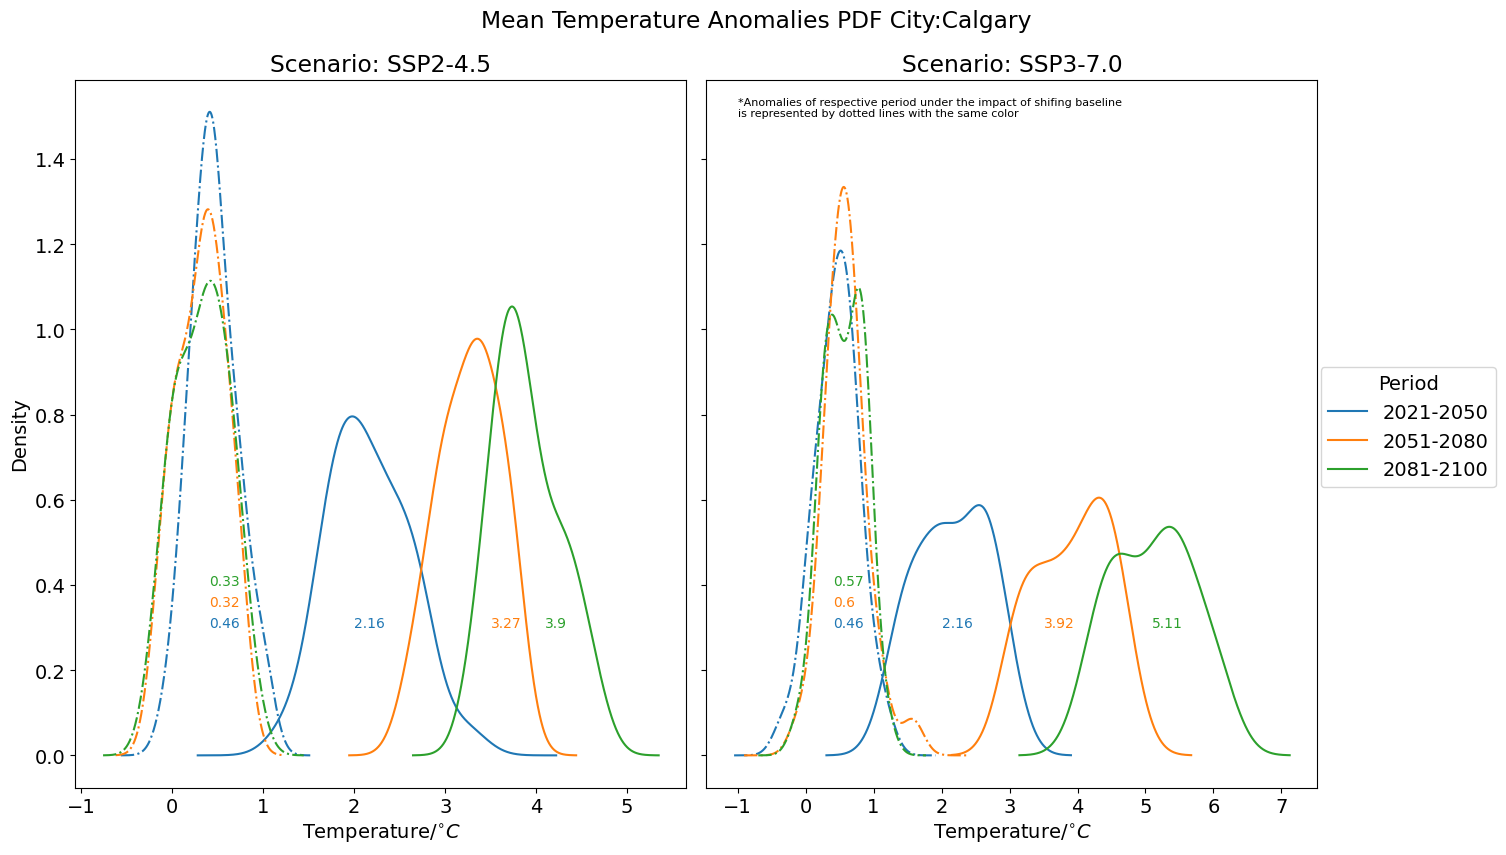

In [130]:
# Annual Mean Temperature PDF for cities and scenarios
colors = ['#1f77b4','#ff7f0e','#2ca02c']
y_m=[0.3,0.35,0.4]
x0s=[2,3.5,4.1]
x1s=[2,3.5,5.1]
for city in folders[0:1]:
    print(city)
    fig,ax=plt.subplots(1,2,figsize=(15,8),layout='constrained',sharey=True)
    fig.suptitle('Mean Temperature Anomalies PDF City:'+city,y=1.05)
# Shifting vs Stationary Baseline    
    for period,color,ym,x0,x1 in zip(shifted_245_annual[city].keys(),colors,y_m,x0s,x1s):
        shifted_245_annual[city][period].mean(['model']).to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.density(ax=ax[0],legend=False,ls='-.',c=color)
        stat_245_annual[city][period].mean(['model']).to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.density(ax=ax[0],legend=False,c=color)
        shifted_370_annual[city][period].mean(['model']).to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.density(ax=ax[1],legend=False,ls='-.',c=color)
        stat_370_annual[city][period].mean(['model']).to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.density(ax=ax[1],legend=False,c=color)

# Tri-decadal Mean
        ax[0].text(0.4,ym,np.round(shifted_245_annual[city][period].mean(['model','year']).values,2),c=color,fontsize=10)
        ax[0].text(x0,0.3,np.round(stat_245_annual[city][period].mean(['model','year']).values,2),c=color,fontsize=10)
        ax[1].text(0.4,ym,np.round(shifted_370_annual[city][period].mean(['model','year']).values,2),c=color,fontsize=10)
        ax[1].text(x1,0.3,np.round(stat_370_annual[city][period].mean(['model','year']).values,2),c=color,fontsize=10)
# # Individual models
#         for i in shifted_245_annual[city][period].model:
#             shifted_245_annual[city][period].sel(model=i).tasmean.to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.kde(ax=ax[0],alpha=0.2,legend=False)
#         for i in ensemble_370_annual[city][period].model:
#             shifted_370_annual[city][period].sel(model=i).tasmean.to_dataframe().reset_index().drop(columns=['spatial_ref','year']).plot.kde(ax=ax[1],alpha=0.2,legend=False)
# Labels
    ax[0].set_xlabel('Temperature/$^{\circ}C$')
    ax[1].set_xlabel('Temperature/$^{\circ}C$')
    h,l = ax[0].get_legend_handles_labels()
    ax[0].set_title('Scenario: SSP2-4.5')
    ax[1].set_title('Scenario: SSP3-7.0')
    ax[1].text(-1, 1.5, '*Anomalies of respective period under the impact of shifing baseline \nis represented by dotted lines with the same color',fontsize=8)
    fig.legend([h[1],h[3],h[5]],['2021-2050','2051-2080','2081-2100'],title='Period', loc='outside right')

In [157]:
shifted_245_over_tmax=shifted_245_tmax['Calgary'].mean(['lat','lon']).chunk({'model':-1})
shifted_245_over_tmax=xr.where(shifted_245_over_tmax>0,1,0)
shifted_245_over_tmax_mean=shifted_245_over_tmax.mean(dim='model').groupby('time.year').sum('time')
shifted_245_over_tmax_q90=shifted_245_over_tmax.quantile(0.9,dim='model').groupby('time.year').sum('time')
shifted_245_over_tmax_q10=shifted_245_over_tmax.quantile(0.1,dim='model').groupby('time.year').sum('time')


In [158]:
stat_370_over_tmax=xr.where(stat_370_tmax['Calgary']>0,1,0).chunk({'model':-1})
stat_370_over_tmax_mean=stat_370_over_tmax.mean(dim='model').groupby('time.year').sum('time')
stat_370_over_tmax_q90=stat_370_over_tmax.quantile(0.9,dim='model').groupby('time.year').sum('time')
stat_370_over_tmax_q10=stat_370_over_tmax.quantile(0.1,dim='model').groupby('time.year').sum('time')

In [159]:
shifted_370_over_tmax=shifted_370_tmax['Calgary'].mean(['lat','lon']).chunk({'model':-1})
shifted_370_over_tmax=xr.where(shifted_370_over_tmax>0,1,0)
shifted_370_over_tmax_mean=shifted_370_over_tmax.mean(dim='model').groupby('time.year').sum('time')
shifted_370_over_tmax_q90=shifted_370_over_tmax.quantile(0.9,dim='model').groupby('time.year').sum('time')
shifted_370_over_tmax_q10=shifted_370_over_tmax.quantile(0.1,dim='model').groupby('time.year').sum('time')

In [160]:
stat_245_over_tmax=xr.where(stat_245_tmax['Calgary']>0,1,0).chunk({'model':-1})
stat_245_over_tmax_mean=stat_245_over_tmax.mean(dim='model').groupby('time.year').sum('time')
stat_245_over_tmax_q90=stat_245_over_tmax.quantile(0.9,dim='model').groupby('time.year').sum('time')
stat_245_over_tmax_q10=stat_245_over_tmax.quantile(0.1,dim='model').groupby('time.year').sum('time')

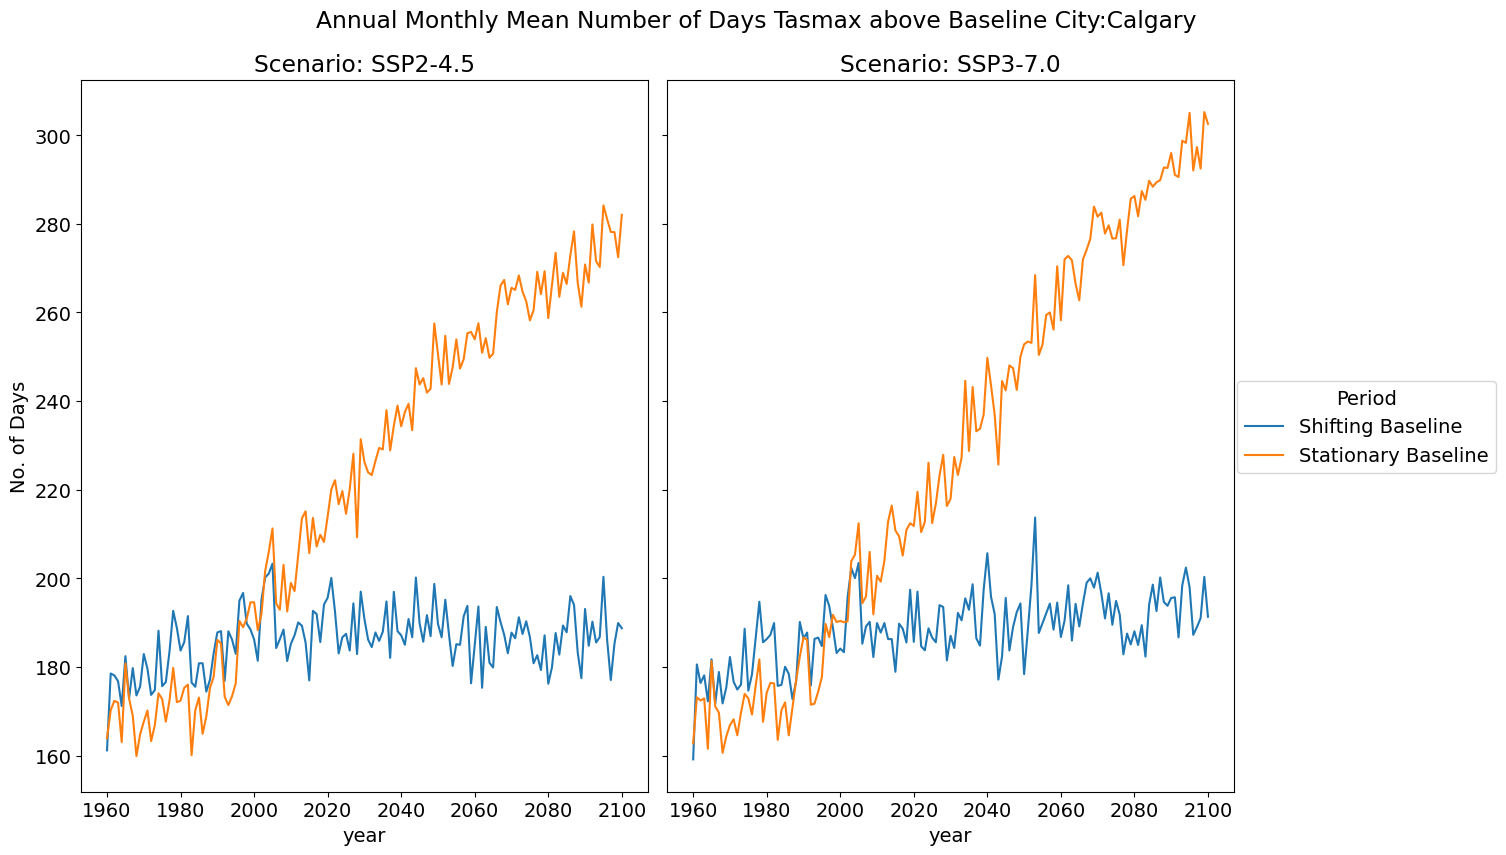

In [165]:
fig,ax=plt.subplots(1,2,figsize=(15,8),layout='constrained',sharey=True)
fig.suptitle('Annual Monthly Mean Number of Days Tasmax above Baseline City:'+city,y=1.05)
shifted_245_over_tmax_mean.plot(ax=ax[0],label='Shifting Baseline')
# ax[0].fill_between(np.arange(1960,2101),shifted_245_over_tmax_q10,shifted_245_over_tmax_q90,alpha=0.2)  
stat_245_over_tmax_mean.plot(ax=ax[0],label='Stationary Baseline')
# ax[0].fill_between(np.arange(1960,2101),stat_245_over_tmax_q10,stat_245_over_tmax_q90,alpha=0.2)  
shifted_370_over_tmax_mean.plot(ax=ax[1])
# ax[1].fill_between(np.arange(1960,2101),shifted_370_over_tmax_q10,shifted_370_over_tmax_q90,alpha=0.2)  
stat_370_over_tmax_mean.plot(ax=ax[1])
# ax[0].fill_between(np.arange(1960,2101),stat_370_over_tmax_q10,stat_370_over_tmax_q90,alpha=0.2)  
ax[0].set_ylabel('No. of Days')
ax[1].set_ylabel('')
ax[0].set_title('Scenario: SSP2-4.5')
ax[1].set_title('Scenario: SSP3-7.0')
fig.legend(title='Period', loc='outside right')